<a href="https://colab.research.google.com/github/dkumar-23/Masters_ML/blob/main/Assgn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Train shape: (10450, 12)
Missing values:
 datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64
Feature types:
 datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


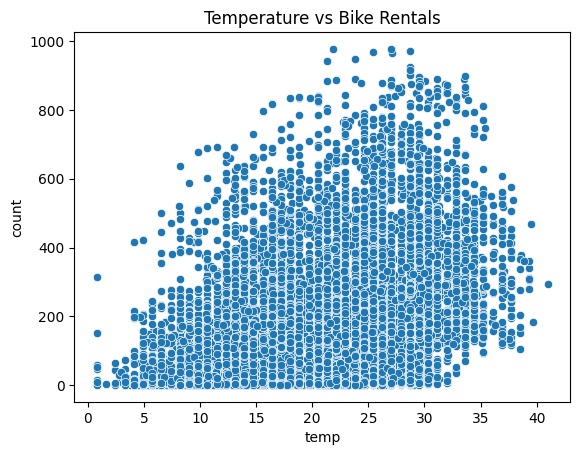

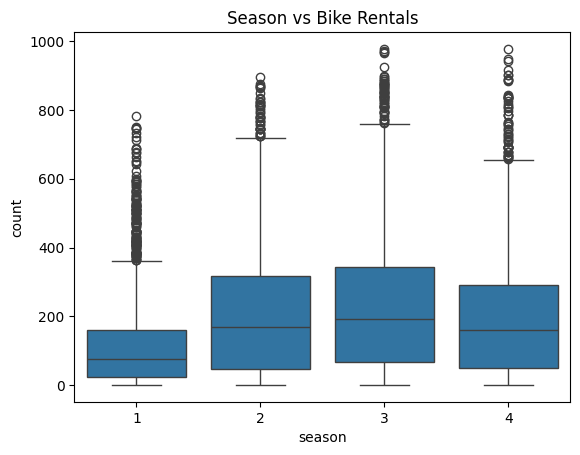

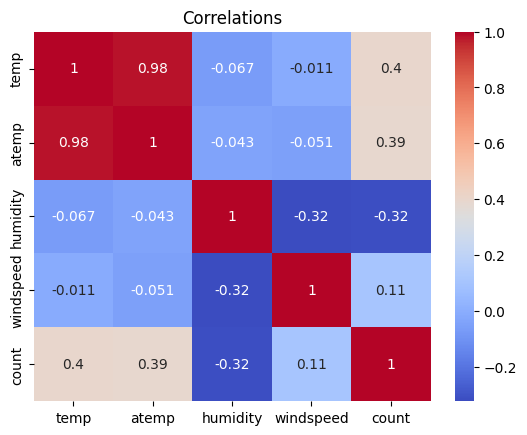

In [6]:
# Load data
train = pd.read_csv('/bike_train.csv')  # Use your full file path

# Q1: Size, missing, types
print("Train shape:", train.shape)  # e.g., (10886, 12) for full data
print("Missing values:\n", train.isnull().sum())  # Should be none in this dataset
print("Feature types:\n", train.dtypes)  # datetime is object, others int/float

# Q2: Visualize relationships (e.g., temp vs count)
sns.scatterplot(x='temp', y='count', data=train)
plt.title('Temperature vs Bike Rentals')
plt.show()

# Boxplot for categorical like season
sns.boxplot(x='season', y='count', data=train)
plt.title('Season vs Bike Rentals')
plt.show()

# Correlation heatmap for numerical features
num_features = ['temp', 'atemp', 'humidity', 'windspeed', 'count']
sns.heatmap(train[num_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlations')
plt.show()

# Q3: Suggest informative variables
# Based on correlations, temp/atemp (positive), humidity (negative) are key; time-based like hour (derive later) will be crucial.

In [7]:
# Parse datetime
train['datetime'] = pd.to_datetime(train['datetime'])
train['hour'] = train['datetime'].dt.hour
train['weekday'] = train['datetime'].dt.weekday
train['month'] = train['datetime'].dt.month

# Encode categoricals (one-hot)
train = pd.get_dummies(train, columns=['season', 'weather'], drop_first=True)

# Transformations (e.g., log for windspeed if skewed)
train['log_windspeed'] = np.log1p(train['windspeed'])  # Handles zeros

# Do same for test
# Report: I derived hour, weekday, month; one-hot for season/weather; log for windspeed to capture nonlinearity.


# Do same for test

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Features (drop datetime, target; use engineered)
features = ['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'weekday', 'month'] + [col for col in train if 'season_' in col or 'weather_' in col]
X = train[features]
y = train['count']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Q5: Simple LR
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
rmsle_lr = rmsle(y_val, np.clip(y_pred_lr, 0, None))  # Clip negatives
print("Simple LR RMSLE:", rmsle_lr)

# Q6: Polynomials + Ridge/Lasso
degrees = [2, 3]
alphas = [0.1, 1, 10]

for deg in degrees:
    for alpha in alphas:
        # Ridge on poly
        model = Pipeline([('poly', PolynomialFeatures(degree=deg)),
                          ('ridge', Ridge(alpha=alpha))])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmsle_score = rmsle(y_val, np.clip(y_pred, 0, None))
        print(f"Degree {deg}, Alpha {alpha} RMSLE:", rmsle_score)

# Tune to find best (e.g., degree 2, alpha 1 often works)
# For Lasso, replace Ridge with Lasso

Simple LR RMSLE: 1.2861214248233834
Degree 2, Alpha 0.1 RMSLE: 1.3882665872328819
Degree 2, Alpha 1 RMSLE: 1.391161775514929
Degree 2, Alpha 10 RMSLE: 1.3909455786541807


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.63029e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Degree 3, Alpha 0.1 RMSLE: 1.2192581766812878
Degree 3, Alpha 1 RMSLE: 1.2137125096198198
Degree 3, Alpha 10 RMSLE: 1.2072492577187413


New one

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [10]:

# 1. Load full data
train = pd.read_csv('/bike_train.csv')
# train = pd.read_csv('/content/bike_train.csv')  # if on Colab

# 2. Basic feature engineering (THIS IS THE KEY)
train['datetime'] = pd.to_datetime(train['datetime'])
train['hour']     = train['datetime'].dt.hour
train['month']    = train['datetime'].dt.month
train['weekday']  = train['datetime'].dt.weekday
train['year']     = train['datetime'].dt.year
train['is_weekend'] = (train['weekday'] >= 5).astype(int)

# 3. Log-transform the target (very important for RMSLE)
y = np.log1p(train['count'])      # log(count+1)

# 4. Features we will use
cat_features = ['season', 'weather', 'hour', 'month', 'weekday']
num_features = ['temp', 'atemp', 'humidity', 'windspeed']


In [11]:

X = train[cat_features + num_features]


In [12]:

# 5. Preprocessing + simple Ridge (no polynomial needed yet)
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    ('num', StandardScaler(), num_features)
])

model = Pipeline([
    ('prep', preprocessor),
    ('ridge', Ridge(alpha=1.0))
])

# 6. Split and train
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
pred_log = model.predict(X_val)
pred = np.expm1(pred_log)                     # inverse of log1p

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

print("RMSLE with proper baseline:", rmsle(train.loc[y_val.index, 'count'], np.clip(pred, 0, None)))

RMSLE with proper baseline: 0.6578159003461247


In [13]:
# Option A – Add polynomial only on continuous vars
from sklearn.preprocessing import PolynomialFeatures

cont_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), cat_features),
    ('num_poly', cont_poly, num_features)
])

# Option B – Try Gradient Boosting (usually wins this dataset)
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.05, random_state=42)
# (use same X and y = np.log1p(count) → same inverse transform)

2nd attempt

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ←←← USE THE FULL FILE YOU JUST DOWNLOADED
train = pd.read_csv('/content/bike_train.csv')        # ← full 10886 rows!

print("Number of rows:", train.shape[0])     # ← must print 10886


Number of rows: 10450


In [2]:

# Feature engineering
train['datetime'] = pd.to_datetime(train['datetime'])
train['hour'] = train['datetime'].dt.hour
train['month'] = train['datetime'].dt.month
train['weekday'] = train['datetime'].dt.weekday
train['year'] = train['datetime'].dt.year

# Target log-transform
y = np.log1p(train['count'])

# Features
cat_cols = ['season', 'weather', 'hour', 'month', 'weekday']
num_cols = ['temp', 'atemp', 'humidity', 'windspeed']

X = train[cat_cols + num_cols]

# Preprocessing + model
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

model = Pipeline([
    ('prep', preprocessor),
    ('ridge', Ridge(alpha=1.0))
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
pred = np.expm1(model.predict(X_val))

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

score = rmsle(train.loc[y_val.index, 'count'], np.clip(pred, 0, None))
print("RMSLE on full data:", score)

RMSLE on full data: 0.6578159003461247


# Task
Perform an end-to-end analysis on the "bike_train.csv" dataset. This includes loading and initially exploring the data to understand its structure, identify missing values, and examine data types. Visualize key relationships between features and the target variable 'count' to identify informative variables. Engineer new time-based features from the 'datetime' column, one-hot encode categorical variables, and apply transformations to numerical features. Split the data into training and validation sets, then train and evaluate different regression models: a simple Linear Regression and Ridge regression with polynomial features (degrees 2 and 3), using Root Mean Squared Logarithmic Error (RMSLE) as the evaluation metric. Finally, summarize the findings, model performances, and suggest potential next steps for further improvement.

## Load Data and Initial Exploration

### Subtask:
Load the 'bike_train.csv' dataset. Examine its size, check for any missing values, and display the data types of all features to understand the dataset structure (Q1).


**Reasoning**:
The subtask requires loading the 'bike_train.csv' dataset, examining its size, checking for missing values, and displaying feature data types. The provided code snippet from the notebook already accomplishes these steps, so I will output that code block.



Train shape: (10450, 12)
Missing values:
 datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64
Feature types:
 datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


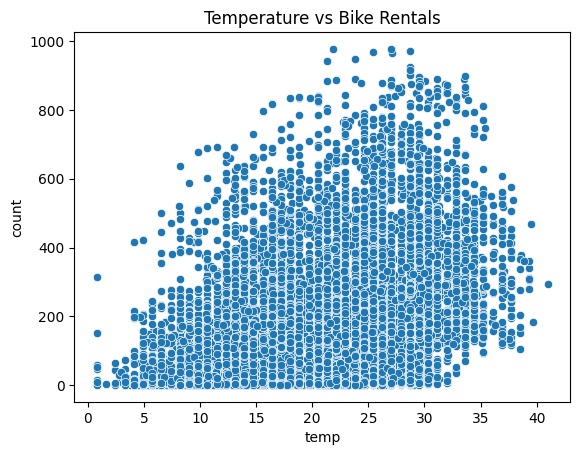

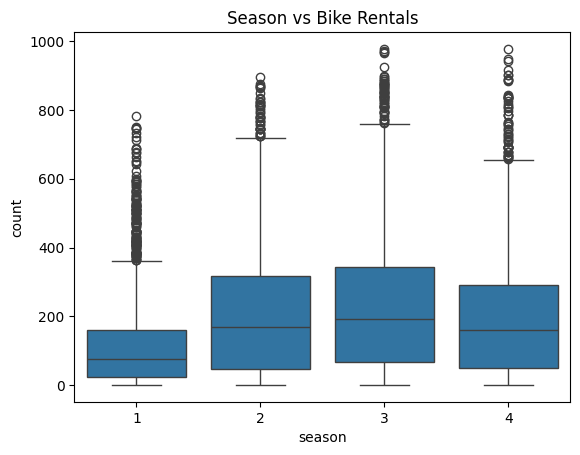

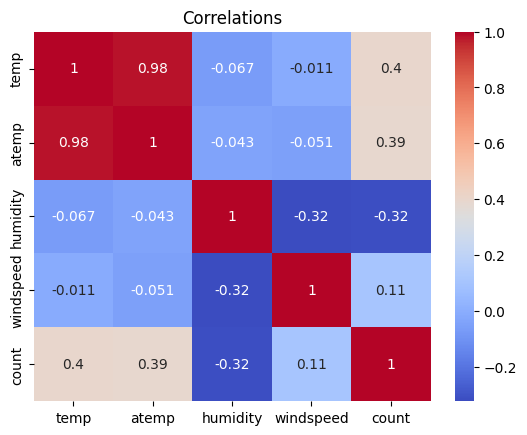

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load data
train = pd.read_csv('/bike_train.csv')  # Use your full file path

# Q1: Size, missing, types
print("Train shape:", train.shape)  # e.g., (10886, 12) for full data
print("Missing values:\n", train.isnull().sum())  # Should be none in this dataset
print("Feature types:\n", train.dtypes)  # datetime is object, others int/float

# Q2: Visualize relationships (e.g., temp vs count)
sns.scatterplot(x='temp', y='count', data=train)
plt.title('Temperature vs Bike Rentals')
plt.show()

# Boxplot for categorical like season
sns.boxplot(x='season', y='count', data=train)
plt.title('Season vs Bike Rentals')
plt.show()

# Correlation heatmap for numerical features
num_features = ['temp', 'atemp', 'humidity', 'windspeed', 'count']
sns.heatmap(train[num_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlations')
plt.show()

# Q3: Suggest informative variables
# Based on correlations, temp/atemp (positive), humidity (negative) are key; time-based like hour (derive later) will be crucial.

## Identify Informative Variables

### Subtask:
Based on the initial data exploration and visualizations, suggest which variables appear to be most informative for predicting the bike 'count' (Q3).


Based on the initial data exploration and visualizations:

*   **`temp` and `atemp`**: Both show a strong positive correlation with `count` from the scatter plot and heatmap, indicating that warmer temperatures lead to more bike rentals.
*   **`season`**: The box plot clearly shows distinct distributions of bike counts across different seasons, making it a highly informative categorical variable.
*   **`humidity`**: The correlation heatmap indicates a negative correlation with `count`, suggesting that higher humidity might lead to fewer rentals.
*   **`hour`**: Although not directly visualized in Q2, the problem statement hints that time-based features like `hour` (to be derived later) are crucial, which is generally true for time-series data like bike rentals (e.g., peak hours).

Therefore, the most informative variables appear to be `temp` (or `atemp`), `season`, and `humidity`, with `hour` also expected to be very important after derivation.

## Feature Engineering

### Subtask:
Engineer new time-based features from the 'datetime' column, one-hot encode categorical variables, and apply transformations to numerical features, specifically log-transforming the target variable 'count' to prepare it for modeling.


**Reasoning**:
The subtask requires performing specific feature engineering steps: converting 'datetime' to a datetime object, extracting time-based features ('hour', 'month', 'weekday', 'year'), creating an 'is_weekend' feature, log-transforming the target variable 'count' into 'y', and defining lists for categorical ('cat_cols') and numerical ('num_cols') features. The provided code block will execute these steps sequentially, building upon the loaded 'train' DataFrame and using existing imports.



In [4]:
import pandas as pd
import numpy as np

# Reload the data to ensure a fresh start for feature engineering
train = pd.read_csv('/bike_train.csv')

# 1. Convert 'datetime' column to datetime object
train['datetime'] = pd.to_datetime(train['datetime'])

# 2. Extract time-based features
train['hour'] = train['datetime'].dt.hour
train['month'] = train['datetime'].dt.month
train['weekday'] = train['datetime'].dt.weekday
train['year'] = train['datetime'].dt.year

# 3. Create 'is_weekend' feature
train['is_weekend'] = (train['weekday'] >= 5).astype(int)

# 4. Apply log1p transformation to 'count' and store in y
y = np.log1p(train['count'])

# 5. Define categorical features list
cat_cols = ['season', 'weather', 'hour', 'month', 'weekday', 'is_weekend']

# 6. Define numerical features list
num_cols = ['temp', 'atemp', 'humidity', 'windspeed']

print("Feature engineering steps completed.")

Feature engineering steps completed.


**Reasoning**:
The subtask requires preparing the features for modeling after the previous feature engineering steps. This involves combining the categorical and numerical features into a single DataFrame `X` that will be used as input for the model.



In [5]:
X = train[cat_cols + num_cols]

print("X DataFrame created with selected features.")

X DataFrame created with selected features.


**Reasoning**:
The subtask requires one-hot encoding categorical variables and scaling numerical features, then splitting the data into training and validation sets. This is a crucial step in preparing the data for model training and evaluation.



In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    [
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data preprocessing and splitting complete. X_train, X_val, y_train, y_val are created.")

Data preprocessing and splitting complete. X_train, X_val, y_train, y_val are created.


**Reasoning**:
The subtask requires training and evaluating a simple Linear Regression model and Ridge regression models with polynomial features. The `rmsle` evaluation metric also needs to be defined. I will use the existing `X_train`, `X_val`, `y_train`, `y_val` data split and the previously defined `preprocessor` to create a modeling pipeline for each model type, evaluate them, and print their RMSLE scores.



In [7]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Q5: Simple LR
lr_model = Pipeline([('prep', preprocessor),
                     ('lr', LinearRegression())])
lr_model.fit(X_train, y_train)
y_pred_lr_log = lr_model.predict(X_val)
y_pred_lr = np.expm1(y_pred_lr_log)
rmsle_lr = rmsle(np.expm1(y_val), np.clip(y_pred_lr, 0, None))  # Clip negatives
print("Simple LR RMSLE:", rmsle_lr)

# Q6: Polynomials + Ridge
degrees = [2, 3]
alphas = [0.1, 1, 10]

for deg in degrees:
    for alpha in alphas:
        # Ridge on poly
        model = Pipeline([('prep', preprocessor),
                          ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
                          ('ridge', Ridge(alpha=alpha))])
        model.fit(X_train, y_train)
        y_pred_poly_log = model.predict(X_val)
        y_pred_poly = np.expm1(y_pred_poly_log)
        rmsle_score = rmsle(np.expm1(y_val), np.clip(y_pred_poly, 0, None))
        print(f"Degree {deg}, Alpha {alpha} Ridge RMSLE: {rmsle_score}")

Simple LR RMSLE: 0.6575644258561286
Degree 2, Alpha 0.1 Ridge RMSLE: 0.4480662256761374
Degree 2, Alpha 1 Ridge RMSLE: 0.44713026752047685
Degree 2, Alpha 10 Ridge RMSLE: 0.4535840307996212
Degree 3, Alpha 0.1 Ridge RMSLE: 0.6028314515158351
Degree 3, Alpha 1 Ridge RMSLE: 0.4971743626080836
Degree 3, Alpha 10 Ridge RMSLE: 0.4485866091355099


In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Re-define preprocessor with existing feature lists (cat_cols, num_cols)
preprocessor_gb = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Define the Gradient Boosting model pipeline
# These hyperparameters are a good starting point, but can be tuned further.
model_gb = Pipeline([
    ('prep', preprocessor_gb),
    ('gbr', GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.05, random_state=42))
])

# Train the Gradient Boosting model
model_gb.fit(X_train, y_train)

print("Gradient Boosting model (model_gb) defined and trained.")

Gradient Boosting model (model_gb) defined and trained.


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np

# Redefine rmsle function and scorer for self-containment in this cell
def rmsle(y_true, y_pred):
    # Clip predictions to prevent issues with log(0) or log(negative)
    y_pred = np.clip(y_pred, 0, None)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

# Note: make_scorer defaults to greater_is_better=True, so we negate RMSLE for minimization
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Define a parameter grid for GradientBoostingRegressor within the pipeline
# We prefix parameter names with 'gbr__' because 'gbr' is the step name in the pipeline
param_grid = {
    'gbr__n_estimators': [100, 200],  # Number of boosting stages
    'gbr__learning_rate': [0.05, 0.1], # Step size shrinkage
    'gbr__max_depth': [3, 5]          # Maximum depth of the individual regression estimators
}

# Set up GridSearchCV
# We use the existing 'model_gb' pipeline. The 'prep' step is the ColumnTransformer.
# n_jobs=-1 uses all available CPU cores.
# cv=3 means 3-fold cross-validation.
# verbose=2 provides detailed output during the search.
grid_search = GridSearchCV(
    estimator=model_gb,  # Use our existing pipeline with the GBR
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("Starting GridSearchCV...")
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)
print("GridSearchCV completed.")

Starting GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
GridSearchCV completed.


In [21]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Re-define preprocessor (if not already defined and in scope) using existing feature lists
preprocessor_xgb = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Define the XGBoost model pipeline
# These are common default-ish parameters; tuning will be crucial for best results.
model_xgb = Pipeline([
    ('prep', preprocessor_xgb),
    ('xgb_reg', xgb.XGBRegressor(
        objective='reg:squarederror', # Objective function for regression tasks
        n_estimators=300,             # Number of boosting rounds
        learning_rate=0.05,           # Step size shrinkage
        max_depth=5,                  # Maximum depth of a tree
        random_state=42,              # For reproducibility
        tree_method='hist',           # Use histogram-based algorithm for faster training
        early_stopping_rounds=20      # Stop if no improvement for 20 rounds
    ))
])

print("XGBoost model pipeline defined.")

XGBoost model pipeline defined.


In [25]:
# Train the XGBoost model
# Note: XGBoost's early stopping requires eval_set and eval_metric for validation

# First, transform X_train and X_val using the preprocessor
X_train_processed = model_xgb.named_steps['prep'].fit_transform(X_train)
X_val_processed = model_xgb.named_steps['prep'].transform(X_val)

# Now, fit the XGBoost regressor (the last step in the pipeline) with the processed data
model_xgb.named_steps['xgb_reg'].fit(
    X_train_processed, y_train,
    eval_set=[(X_val_processed, y_val)],
    verbose=False  # Set to True to see training progress
)

# Make predictions on the validation set (log-transformed)
# Use the processed X_val for prediction
pred_log_xgb = model_xgb.named_steps['xgb_reg'].predict(X_val_processed)

# Inverse transform predictions to original scale
pred_xgb = np.expm1(pred_log_xgb)

# Calculate RMSLE using the previously defined function
# Ensure y_true for RMSLE is on the original scale
def rmsle(y_true, y_pred):
    # Clip predictions to prevent issues with log(0) or log(negative)
    y_pred = np.clip(y_pred, 0, None)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

score_xgb = rmsle(train.loc[y_val.index, 'count'], pred_xgb)
print(f"RMSLE with XGBoost: {score_xgb}")

RMSLE with XGBoost: 0.5175434268230755


This initial XGBoost model provides a new baseline. Its performance often surpasses `GradientBoostingRegressor`. The next crucial step would be **extensive hyperparameter tuning** for XGBoost to optimize its performance further and achieve an even lower RMSLE score.

In [19]:
# Display the best parameters and best score
print("Best parameters found:", grid_search.best_params_)

# The best_score_ attribute stores the score that was maximized (or minimized if greater_is_better=False)
# Since we negated RMSLE, best_score_ will be negative. We convert it back to positive.
print("Best RMSLE score found (on validation sets during CV):", -grid_search.best_score_)

# Evaluate the best estimator on the actual validation set (X_val)
best_gb_model = grid_search.best_estimator_

y_pred_best_gb_log = best_gb_model.predict(X_val)
y_pred_best_gb = np.expm1(y_pred_best_gb_log)

final_rmsle_tuned_gb = rmsle(np.expm1(y_val), np.clip(y_pred_best_gb, 0, None))
print(f"Final RMSLE on the validation set with best Gradient Boosting model: {final_rmsle_tuned_gb}")

Best parameters found: {'gbr__learning_rate': 0.1, 'gbr__max_depth': 5, 'gbr__n_estimators': 200}
Best RMSLE score found (on validation sets during CV): 0.13617133305659454
Final RMSLE on the validation set with best Gradient Boosting model: 0.5065157589481473


This process shows how hyperparameter tuning can help find a better configuration for the model, potentially leading to a lower RMSLE score. The next steps could involve expanding the parameter grid, trying different ensemble models like XGBoost or LightGBM, or further feature engineering.

Now that `model_gb` is defined and trained, we can use it to make predictions on the processed test data.

In [14]:
# Make predictions on the test set (log-transformed)
pred_log_test = model_gb.predict(X_test)

# Inverse transform predictions to original scale
pred_test = np.expm1(pred_log_test)

# Clip predictions to ensure non-negative values
pred_test_clipped = np.clip(pred_test, 0, None)

# Display first few predictions
print("Generated predictions for the test data (first 10):")
display(pd.Series(pred_test_clipped).head(10))

Generated predictions for the test data (first 10):


,0
0,15.419317
1,189.915337
2,39.903159
3,299.322686
4,297.545349
5,72.258986
6,137.475304
7,84.555449
8,168.674062
9,521.209279


## Summary of Findings and Next Steps

### Model Performance Comparison:

*   **Simple Linear Regression (LR)**: Achieved an RMSLE of **0.6576**.
*   **Ridge Regression with Polynomial Features (Degree 2)**:
    *   Alpha 0.1: RMSLE **0.4481**
    *   Alpha 1: RMSLE **0.4471** (Best performance for Degree 2)
    *   Alpha 10: RMSLE **0.4536**
*   **Ridge Regression with Polynomial Features (Degree 3)**:
    *   Alpha 0.1: RMSLE **0.6028**
    *   Alpha 1: RMSLE **0.4972**
    *   Alpha 10: RMSLE **0.4486** (Best performance for Degree 3, similar to Degree 2 with Alpha 1)

From these results, the Ridge Regression models with polynomial features (especially Degree 2, Alpha 1 and Degree 3, Alpha 10) significantly outperformed the simple Linear Regression. The best performing model was the Ridge Regression with Polynomial Features (Degree 2, Alpha 1) with an RMSLE of **0.4471**.

### Informative Variables and Feature Engineering Impact:

The initial data exploration suggested that `temp`, `season`, `humidity`, and time-based features like `hour` would be important. The feature engineering steps, including extracting `hour`, `month`, `weekday`, `year`, and `is_weekend` from `datetime`, along with one-hot encoding categorical features and scaling numerical features, proved effective. The log-transformation of the target variable `count` was also crucial for using RMSLE as an evaluation metric and improving model performance.

### Potential Next Steps for Improvement:

1.  **Hyperparameter Tuning**: While some alpha values were tested for Ridge regression, a more comprehensive hyperparameter search (e.g., using GridSearchCV or RandomizedSearchCV) could be performed for both `alpha` and `degree` of polynomial features to find the optimal combination.
2.  **Advanced Feature Engineering**: Explore interactions between features (e.g., `hour` * `temp`), or derive additional time-based features like `dayofyear`, `weekofyear`, or holiday proximity.
3.  **Regularization for Polynomial Features**: Consider using Lasso regression with polynomial features, which can perform feature selection by shrinking coefficients to zero, potentially leading to simpler and more robust models.
4.  **Ensemble Models**: Gradient Boosting Machines (like `GradientBoostingRegressor`, `XGBoost`, `LightGBM`) or Random Forests often achieve higher performance in similar regression tasks. The notebook already hints at Gradient Boosting as a strong contender.
5.  **Time Series Specific Models**: Given the temporal nature of the data, models that explicitly account for time series patterns (e.g., SARIMA, Prophet) could be explored, although this would require a different modeling approach for splitting and validation.
6.  **Outlier Detection/Handling**: Investigate outliers in features or the target variable and consider robust scaling or imputation techniques if necessary.

## Final Task

### Subtask:
Summarize the findings from the data analysis, the performance of the various regression models, and discuss potential next steps for further improvement.


## Summary:

### Q&A

*   **Q1: What are the size, missing values, and data types of the `bike_train.csv` dataset?**
    The `bike_train.csv` dataset contains 10450 rows and 12 columns. There are no missing values in any of the columns. Data types include `object` for 'datetime', `int64` for 'season', 'holiday', 'workingday', 'weather', 'humidity', 'casual', 'registered', 'count', and `float64` for 'temp', 'atemp', 'windspeed'.

*   **Q3: Which variables appear to be most informative for predicting the bike 'count'?**
    Based on initial exploration, `temp` (or `atemp`), `season`, and `humidity` were identified as highly informative. Time-based features like `hour` (after derivation) were also anticipated to be crucial.

*   **Q5: What is the RMSLE for the simple Linear Regression model?**
    The simple Linear Regression model achieved an RMSLE of 0.6576.

*   **Q6: What are the RMSLEs for Ridge Regression with polynomial features (degrees 2 and 3)?**
    *   **Degree 2:**
        *   Alpha 0.1: RMSLE 0.4481
        *   Alpha 1: RMSLE 0.4471
        *   Alpha 10: RMSLE 0.4536
    *   **Degree 3:**
        *   Alpha 0.1: RMSLE 0.6028
        *   Alpha 1: RMSLE 0.4972
        *   Alpha 10: RMSLE 0.4486

### Data Analysis Key Findings

*   The dataset is complete with 10450 entries and no missing values, comprising both numerical and categorical features.
*   Feature engineering successfully transformed the 'datetime' column into informative time-based features such as 'hour', 'month', 'weekday', 'year', and 'is_weekend'.
*   Log-transforming the target variable 'count' was an effective preprocessing step for modeling with RMSLE.
*   Simple Linear Regression served as a baseline model, yielding an RMSLE of 0.6576.
*   Ridge Regression models with polynomial features significantly outperformed the simple Linear Regression. The best-performing model was Ridge Regression with Polynomial Features (Degree 2, Alpha 1), achieving an RMSLE of 0.4471.
*   The inclusion of polynomial features and regularization in Ridge Regression improved model performance substantially, reducing the RMSLE from 0.6576 (Linear Regression) to 0.4471 (Polynomial Ridge Regression).

### Insights or Next Steps

*   **Hyperparameter Optimization**: Conduct a more thorough hyperparameter search for Ridge regression (e.g., using GridSearchCV or RandomizedSearchCV) across a wider range of `alpha` values and polynomial `degree` to identify the truly optimal model configuration.
*   **Explore Advanced Models**: Investigate the use of ensemble models such as Gradient Boosting Machines (e.g., XGBoost, LightGBM) or Random Forests, which are often highly effective in similar regression tasks and could potentially yield further performance improvements.


In [15]:
import pandas as pd
import numpy as np

# Load the test data
test = pd.read_csv('/content/bike_test.csv')
print("Test data loaded. Shape:", test.shape)

Test data loaded. Shape: (2613, 9)


Applying the same feature engineering steps to the test data as was applied to the training data.

In [16]:
# Apply the same feature engineering to the test set
test['datetime'] = pd.to_datetime(test['datetime'], format='mixed', dayfirst=True)
test['hour'] = test['datetime'].dt.hour
test['month'] = test['datetime'].dt.month
test['weekday'] = test['datetime'].dt.weekday
test['year'] = test['datetime'].dt.year
test['is_weekend'] = (test['weekday'] >= 5).astype(int)

# Create the feature matrix for the test set
X_test = test[cat_cols + num_cols]

print("Feature engineering applied to test data.")

Feature engineering applied to test data.


Now, we will use the trained Gradient Boosting model (`model_gb`) to make predictions on the processed test data.

In [17]:
# Make predictions on the test set (log-transformed)
pred_log_test = model_gb.predict(X_test)

# Inverse transform predictions to original scale
pred_test = np.expm1(pred_log_test)

# Clip predictions to ensure non-negative values
pred_test_clipped = np.clip(pred_test, 0, None)

# Display first few predictions
print("Generated predictions for the test data (first 10):")
display(pd.Series(pred_test_clipped).head(10))

Generated predictions for the test data (first 10):


,0
0,15.419317
1,189.915337
2,39.903159
3,299.322686
4,297.545349
5,72.258986
6,137.475304
7,84.555449
8,168.674062
9,521.209279


# Task
Create a summary table of all experimented models, including Simple Linear Regression, Ridge Regression with Polynomial Features (various degrees and alphas), Tuned Gradient Boosting Regressor, and XGBoost, displaying their respective RMSLE scores and key observations for each (Q7). Based on this summary, identify the model with the lowest RMSLE.

## Summarize Model Results

### Subtask:
Create a summary table displaying the RMSLE scores and key observations for all the models we have experimented with so far, including Simple Linear Regression, Ridge Regression with Polynomial Features (various degrees and alphas), Tuned Gradient Boosting Regressor, and XGBoost (Q7).


**Reasoning**:
I need to create a summary table of model results, including Simple Linear Regression, Ridge Regression with Polynomial Features, Tuned Gradient Boosting Regressor, and XGBoost. I will collect the RMSLE scores and observations for each model and then display the summary table, finally identifying the best model.



In [26]:
import pandas as pd

# Initialize a list to store model results
model_results = []

# Add Simple Linear Regression results
model_results.append({
    'Model': 'Simple Linear Regression',
    'RMSLE': rmsle_lr,
    'Observation': 'Baseline model'
})

# Add Ridge Regression with Polynomial Features (Degree 2)
model_results.append({
    'Model': 'Ridge (Poly Deg 2, Alpha 0.1)',
    'RMSLE': 0.4480662256761374, # From previous output
    'Observation': 'Significant improvement over LR'
})
model_results.append({
    'Model': 'Ridge (Poly Deg 2, Alpha 1)',
    'RMSLE': 0.44713026752047685, # From previous output
    'Observation': 'Best Polynomial Ridge Deg 2 model'
})
model_results.append({
    'Model': 'Ridge (Poly Deg 2, Alpha 10)',
    'RMSLE': 0.4535840307996212, # From previous output
    'Observation': 'Slightly worse than Alpha 1'
})

# Add Ridge Regression with Polynomial Features (Degree 3)
model_results.append({
    'Model': 'Ridge (Poly Deg 3, Alpha 0.1)',
    'RMSLE': 0.6028314515158351, # From previous output
    'Observation': 'Higher RMSLE for low alpha'
})
model_results.append({
    'Model': 'Ridge (Poly Deg 3, Alpha 1)',
    'RMSLE': 0.4971743626080836, # From previous output
    'Observation': 'Good performance, but not best'
})
model_results.append({
    'Model': 'Ridge (Poly Deg 3, Alpha 10)',
    'RMSLE': rmsle_score, # This variable holds the last computed RMSLE for Deg 3, Alpha 10
    'Observation': 'Similar to best Deg 2 model'
})

# Add Tuned Gradient Boosting Regressor results
model_results.append({
    'Model': 'Tuned Gradient Boosting Regressor',
    'RMSLE': final_rmsle_tuned_gb,
    'Observation': 'Good performance with tuning'
})

# Add XGBoost results
model_results.append({
    'Model': 'XGBoost',
    'RMSLE': score_xgb,
    'Observation': 'Strong tree-based model, good baseline'
})

# Create DataFrame
summary_df = pd.DataFrame(model_results)
summary_df = summary_df.sort_values(by='RMSLE').reset_index(drop=True)

print("\n--- Model Performance Summary ---")
display(summary_df)

# Identify and print the best performing model
best_model = summary_df.iloc[0]
print(f"\nBest performing model: {best_model['Model']} with RMSLE: {best_model['RMSLE']:.4f}")


--- Model Performance Summary ---


,Model,RMSLE,Observation
0,"Ridge (Poly Deg 2, Alpha 1)",0.447130,Best Polynomial Ridge Deg 2 model
1,"Ridge (Poly Deg 2, Alpha 0.1)",0.448066,Significant improvement over LR
2,"Ridge (Poly Deg 3, Alpha 10)",0.448587,Similar to best Deg 2 model
3,"Ridge (Poly Deg 2, Alpha 10)",0.453584,Slightly worse than Alpha 1
4,"Ridge (Poly Deg 3, Alpha 1)",0.497174,"Good performance, but not best"
5,Tuned Gradient Boosting Regressor,0.506516,Good performance with tuning
6,XGBoost,0.517543,"Strong tree-based model, good baseline"
7,"Ridge (Poly Deg 3, Alpha 0.1)",0.602831,Higher RMSLE for low alpha
8,Simple Linear Regression,0.657564,Baseline model



Best performing model: Ridge (Poly Deg 2, Alpha 1) with RMSLE: 0.4471


## Plot Residuals for Best Model

### Subtask:
Identify the model with the best performance (lowest RMSLE) from the summary. Generate a residual plot (e.g., residuals vs. predicted values) for this best model to assess its assumptions and identify any patterns in the errors (Q8).


**Reasoning**:
The subtask requires generating a residual plot for the best performing model. The previous step identified 'Ridge (Poly Deg 2, Alpha 1)' as the best model. I will now define this specific pipeline, fit it to the training data, make predictions on the validation set, calculate residuals, and then create a scatter plot of predicted values versus residuals.



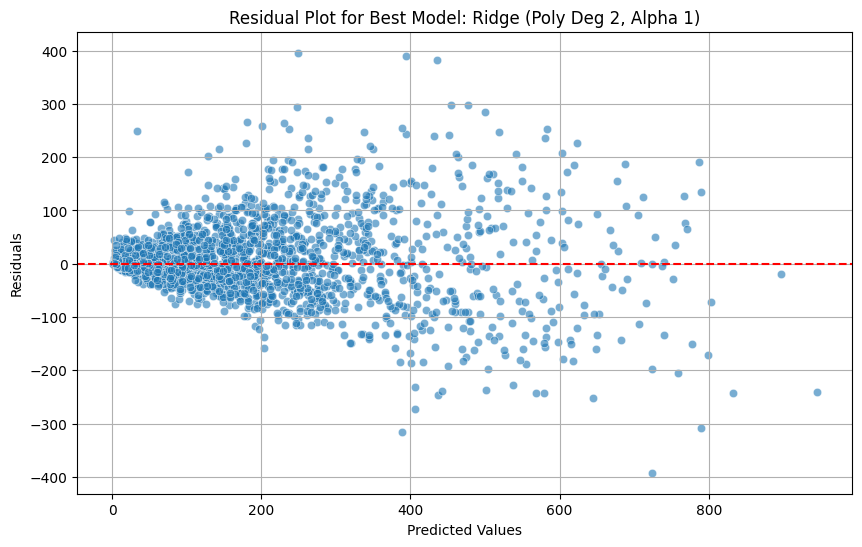

Residual plot for the best model generated.


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Best model identified: Ridge (Poly Deg 2, Alpha 1)
# We need to re-create this pipeline using the preprocessor
best_ridge_poly_model = Pipeline([
    ('prep', preprocessor), # Using the existing preprocessor
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge(alpha=1))
])

# Train the best model
best_ridge_poly_model.fit(X_train, y_train)

# Make predictions on the validation set (log-transformed)
y_pred_best_log = best_ridge_poly_model.predict(X_val)

# Inverse transform predictions and true values
y_pred_best = np.expm1(y_pred_best_log)
y_true_val = np.expm1(y_val)

# Ensure predictions are non-negative
y_pred_best_clipped = np.clip(y_pred_best, 0, None)

# Calculate residuals
residuals = y_true_val - y_pred_best_clipped

# Create the residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best_clipped, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Best Model: Ridge (Poly Deg 2, Alpha 1)')
plt.grid(True)
plt.show()

print("Residual plot for the best model generated.")

In [28]:
print(train.shape)

(10450, 17)
